# Evaluation des Neuronalen Netzes zur Werkzeug-Erkennung
Das Notebook [semesterarbeit-training.ipynb](semesterarbeit-training.ipynb) produzierte als Ausgabe ein fertig trainiertes neuronales Netz, sowie eine Aufsplittung des Werkzeug-Datensatzes in einen Trainings- und einen Testdatensatz. Hier wollen wir das Modell laden und auf dem Testdatensatz evaluieren.

Die Daten wurden bereits im Training-Notebook extrahiert und in ZIP-Dateien (`training_Baumstruktur.zip` und `testing_Baumstruktur.zip`) gespeichert.

In [1]:
# Installiere alle benötigten Abhängigkeiten
import subprocess
import sys

def install_package(package_name, import_name=None):
    """Installiert ein Paket falls es nicht vorhanden ist"""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installiere {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name], 
                                stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"✓ {package_name} wurde installiert")
            return True
        except Exception as e:
            print(f"✗ Fehler beim Installieren von {package_name}: {e}")
            return False

# Liste aller benötigten Pakete
required_packages = [
    ("tensorflow>=2.10.0", "tensorflow"),
    ("numpy>=1.20.0", "numpy"),
    ("matplotlib>=3.3.0", "matplotlib"),
    ("pandas>=1.3.0", "pandas"),
    ("scikit-learn>=1.0.0", "sklearn"),
    ("seaborn>=0.11.0", "seaborn"),
    ("scipy>=1.7.0,<1.11.0", "scipy"),
]

print("Prüfe Abhängigkeiten...")
all_installed = True
for package, import_name in required_packages:
    if not install_package(package, import_name):
        all_installed = False

# Spezielle Behandlung für scikit-plot
try:
    import scikitplot
    SKPLT_AVAILABLE = True
    print("✓ scikit-plot ist verfügbar")
except ImportError:
    SKPLT_AVAILABLE = False
    print("⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Visualisierungen.")
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Erstelle Mock-Objekt für scikit-plot
    class MockSkpltMetrics:
        def plot_confusion_matrix(self, y_true, y_pred, labels=None, x_tick_rotation=0, ax=None):
            cm = confusion_matrix(y_true, y_pred, labels=labels)
            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 8))
            
            # Bestimme die Labels für die Achsen
            if labels is not None:
                # Konvertiere zu Liste falls es ein numpy Array ist
                if hasattr(labels, 'tolist'):
                    tick_labels = labels.tolist()
                else:
                    tick_labels = list(labels)
            else:
                tick_labels = sorted(set(list(y_true) + list(y_pred)))
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                       xticklabels=tick_labels, 
                       yticklabels=tick_labels)
            ax.set_xlabel('Vorhergesagte Klasse')
            ax.set_ylabel('Tatsächliche Klasse')
            ax.set_title('Confusion Matrix')
            if x_tick_rotation:
                plt.setp(ax.get_xticklabels(), rotation=x_tick_rotation, ha='right')
            return ax
        
        def plot_precision_recall(self, y_true, y_proba, ax=None):
            from sklearn.metrics import precision_recall_curve, auc
            from sklearn.preprocessing import label_binarize
            
            classes = sorted(set(y_true))
            y_bin = label_binarize(y_true, classes=classes)
            
            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 8))
            
            for i, class_name in enumerate(classes):
                precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
                ax.plot(recall, precision, label=f'{class_name} (AUC={auc(recall, precision):.2f})')
            
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title('Precision-Recall Curve')
            return ax
        
        def plot_roc(self, y_true, y_proba, ax=None):
            from sklearn.metrics import roc_curve, auc
            from sklearn.preprocessing import label_binarize
            
            classes = sorted(set(y_true))
            y_bin = label_binarize(y_true, classes=classes)
            
            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 8))
            
            for i, class_name in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
                ax.plot(fpr, tpr, label=f'{class_name} (AUC={auc(fpr, tpr):.2f})')
            
            ax.plot([0, 1], [0, 1], 'k--', label='Random')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('ROC Curve')
            return ax
    
    class MockScikitplot:
        def __init__(self):
            self.metrics = MockSkpltMetrics()
    
    scikitplot = MockScikitplot()

if all_installed:
    print("\n✓ Alle Abhängigkeiten sind installiert!")

# Standard-Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
from pathlib import Path

Prüfe Abhängigkeiten...


d:\dev\anaconda\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Visualisierungen.

✓ Alle Abhängigkeiten sind installiert!


In [2]:
# Prüfe ob die Baumstruktur bereits vorhanden ist oder aus ZIP-Dateien entpackt werden muss
import zipfile

Baumstrukturpfad = Path('Baumstruktur')
testBaumstrukturpfad = Baumstrukturpfad / '2_Baumstruktur_test'

# Prüfe ob Test-Baumstruktur bereits existiert
if testBaumstrukturpfad.exists() and any(testBaumstrukturpfad.iterdir()):
    Baumstruktur_schon_vorhanden = True
    print(f"✓ Test-Baumstruktur gefunden: {testBaumstrukturpfad}")
else:
    # Versuche ZIP-Datei zu entpacken
    zip_test = Path('testing_Baumstruktur.zip')
    if zip_test.exists():
        print(f"Entpacke {zip_test}...")
        Baumstrukturpfad.mkdir(exist_ok=True)
        with zipfile.ZipFile(zip_test, 'r') as zip_ref:
            zip_ref.extractall(Baumstrukturpfad)
        testBaumstrukturpfad = Baumstrukturpfad / '2_Baumstruktur_test'
        if not testBaumstrukturpfad.exists():
            testBaumstrukturpfad = Baumstrukturpfad / 'test'
        Baumstruktur_schon_vorhanden = True
        print(f"✓ Test-Daten entpackt: {testBaumstrukturpfad}")
    else:
        Baumstruktur_schon_vorhanden = False
        print(f"⚠ WARNUNG: {zip_test} nicht gefunden und keine Baumstruktur vorhanden!")

✓ Test-Baumstruktur gefunden: Baumstruktur\2_Baumstruktur_test


## 🔍 Diagnose: Datenanzahl prüfen

Diese Zelle zeigt, wie viele Bilder wo gefunden wurden und ob die Daten aktuell sind.


In [3]:
# ============================================================================
# DIAGNOSE: Prüfe Datenanzahl und -qualität
# ============================================================================
from pathlib import Path
import zipfile

print("=" * 70)
print("DATEN-DIAGNOSE")
print("=" * 70)

# Initialisiere Variablen
total_extracted = 0
total_train = 0
total_test = 0

# 1. Prüfe extracted-Ordner (aktuellste Daten)
extracted_path = Path('extracted')
if extracted_path.exists():
    print("\n1. Extrahierte Bilder (extracted/):")
    for klasse in ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']:
        klasse_path = extracted_path / klasse
        if klasse_path.exists():
            count = len(list(klasse_path.glob('*.*')))
            total_extracted += count
            print(f"   {klasse:20s}: {count:4d} Bilder")
    print(f"   {'GESAMT':20s}: {total_extracted:4d} Bilder")
else:
    print("\n1. Extrahierte Bilder: ❌ Ordner 'extracted' existiert nicht!")
    print("   → Führen Sie zuerst das Objektextraktions-Notebook aus!")

# 2. Prüfe ZIP-Dateien
print("\n2. ZIP-Dateien:")
zip_train = Path('training_Baumstruktur.zip')
zip_test = Path('testing_Baumstruktur.zip')

if zip_train.exists():
    size_mb = zip_train.stat().st_size / 1024 / 1024
    print(f"   ✓ training_Baumstruktur.zip: {size_mb:.2f} MB")
else:
    print(f"   ❌ training_Baumstruktur.zip: FEHLT")
    print("      → Führen Sie das Objektextraktions-Notebook aus, um ZIP zu erstellen!")

if zip_test.exists():
    size_mb = zip_test.stat().st_size / 1024 / 1024
    print(f"   ✓ testing_Baumstruktur.zip: {size_mb:.2f} MB")
else:
    print(f"   ❌ testing_Baumstruktur.zip: FEHLT")
    print("      → Führen Sie das Objektextraktions-Notebook aus, um ZIP zu erstellen!")

# 3. Prüfe entpackte Baumstruktur
print("\n3. Entpackte Baumstruktur (Baumstruktur/):")
baumstruktur_path = Path('Baumstruktur')
if baumstruktur_path.exists():
    train_path = baumstruktur_path / '2_Baumstruktur_train'
    test_path = baumstruktur_path / '2_Baumstruktur_test'
    
    if train_path.exists():
        print(f"   ✓ Train-Ordner: {train_path}")
        for klasse_dir in train_path.iterdir():
            if klasse_dir.is_dir():
                count = len(list(klasse_dir.glob('*.*')))
                total_train += count
                print(f"      {klasse_dir.name:20s}: {count:4d} Bilder")
        print(f"      {'GESAMT':20s}: {total_train:4d} Bilder")
    else:
        print(f"   ❌ Train-Ordner fehlt: {train_path}")
    
    if test_path.exists():
        print(f"   ✓ Test-Ordner: {test_path}")
        for klasse_dir in test_path.iterdir():
            if klasse_dir.is_dir():
                count = len(list(klasse_dir.glob('*.*')))
                total_test += count
                print(f"      {klasse_dir.name:20s}: {count:4d} Bilder")
        print(f"      {'GESAMT':20s}: {total_test:4d} Bilder")
    else:
        print(f"   ❌ Test-Ordner fehlt: {test_path}")
else:
    print(f"   ❌ Baumstruktur-Ordner existiert nicht!")
    print("      → Führen Sie das Training-Notebook aus, um Daten zu entpacken!")

# 4. Vergleich und Empfehlungen
print("\n4. Vergleich und Empfehlungen:")
if extracted_path.exists() and baumstruktur_path.exists():
    total_baumstruktur = total_train + total_test
    if total_extracted > total_baumstruktur:
        diff = total_extracted - total_baumstruktur
        print(f"   ⚠️ WARNUNG: {diff} neue Bilder in 'extracted/' gefunden!")
        print(f"      → Extrahierte Bilder: {total_extracted}")
        print(f"      → In Baumstruktur: {total_baumstruktur} ({total_train} Train + {total_test} Test)")
        print(f"      → Führen Sie das Objektextraktions-Notebook aus, um:")
        print(f"         1. Alle {total_extracted} Bilder zu verarbeiten")
        print(f"         2. Train/Test Split durchzuführen (80/20)")
        print(f"         3. ZIP-Dateien neu zu erstellen")
    elif total_extracted < total_baumstruktur:
        diff = total_baumstruktur - total_extracted
        print(f"   ⚠️ HINWEIS: {diff} Bilder mehr in Baumstruktur als in extracted/")
        print(f"      → Dies kann passieren, wenn Bilder mehrfach extrahiert wurden")
        print(f"      → Oder wenn die ZIP-Dateien neuere Daten enthalten")
    else:
        print(f"   ✓ Alle extrahierten Bilder sind in Train/Test aufgeteilt")
        print(f"      → Extrahierte: {total_extracted} = Train {total_train} + Test {total_test}")
        print(f"      → Verhältnis: {total_train/total_extracted*100:.1f}% Train, {total_test/total_extracted*100:.1f}% Test")

print("\n" + "=" * 70)


DATEN-DIAGNOSE

1. Extrahierte Bilder (extracted/):
   schraubenschluessel :  148 Bilder
   schraubenzieher     :  268 Bilder
   seidenschneider     :  165 Bilder
   GESAMT              :  581 Bilder

2. ZIP-Dateien:
   ✓ training_Baumstruktur.zip: 1.18 MB
   ✓ testing_Baumstruktur.zip: 0.30 MB

3. Entpackte Baumstruktur (Baumstruktur/):
   ✓ Train-Ordner: Baumstruktur\2_Baumstruktur_train
      schraubenschluessel :  134 Bilder
      schraubenzieher     :  246 Bilder
      seidenschneider     :  158 Bilder
      GESAMT              :  538 Bilder
   ✓ Test-Ordner: Baumstruktur\2_Baumstruktur_test
      schraubenschluessel :   45 Bilder
      schraubenzieher     :   88 Bilder
      seidenschneider     :   57 Bilder
      GESAMT              :  190 Bilder

4. Vergleich und Empfehlungen:
   ⚠️ HINWEIS: 147 Bilder mehr in Baumstruktur als in extracted/
      → Dies kann passieren, wenn Bilder mehrfach extrahiert wurden
      → Oder wenn die ZIP-Dateien neuere Daten enthalten



In [4]:
# Modell laden - verwende lokales Modell aus dem Training
Datensatzname = 'Werkzeuge'  # Muss mit dem Training-Notebook übereinstimmen
model_output_path = Path('model_output') / 'model'
model_path = model_output_path / f'model_{Datensatzname}.keras'

if not model_path.exists():
    # Fallback: Suche nach anderen möglichen Pfaden
    alternative_paths = [
        Path('model') / f'model_{Datensatzname}.keras',
        Path(f'model_{Datensatzname}.keras'),
    ]
    found = False
    for alt_path in alternative_paths:
        if alt_path.exists():
            model_path = alt_path
            found = True
            break
    
    if not found:
        raise FileNotFoundError(f"Modell nicht gefunden! Erwartet: {model_path}\n"
                              f"Bitte führen Sie zuerst das Training-Notebook aus.")

print(f"Lade Modell von: {model_path.absolute()}")
loaded_model = tf.keras.models.load_model(str(model_path))
print("✓ Modell erfolgreich geladen")

Lade Modell von: d:\dev\git\privat\Studium\dsci-semesterarebeit\model_output\model\model_Werkzeuge.keras
✓ Modell erfolgreich geladen


In [5]:
# Zeige Status
print(f"Baumstruktur vorhanden: {Baumstruktur_schon_vorhanden}")
if Baumstruktur_schon_vorhanden:
    print(f"Test-Pfad: {testBaumstrukturpfad}")

Baumstruktur vorhanden: True
Test-Pfad: Baumstruktur\2_Baumstruktur_test


In [6]:
if Baumstruktur_schon_vorhanden:
    # Stelle sicher, dass testBaumstrukturpfad definiert ist
    if 'testBaumstrukturpfad' not in globals():
        testBaumstrukturpfad = Baumstrukturpfad / '2_Baumstruktur_test'
        if not testBaumstrukturpfad.exists():
            testBaumstrukturpfad = Baumstrukturpfad / 'test'
    
    np.set_printoptions(suppress=True, linewidth=500)
    
    # Suche nach Bildern in verschiedenen Formaten
    image_extensions = ['*.JPEG', '*.jpeg', '*.JPG', '*.jpg', '*.PNG', '*.png']
    testBilder_fn = []
    for ext in image_extensions:
        testBilder_fn.extend(list(testBaumstrukturpfad.glob(f'*/*{ext[1:]}')))  # Entferne * für glob
    
    testBilder_fn = pd.Series(testBilder_fn)
    testKlassenlabel = pd.Series([fn.parent.name for fn in testBilder_fn], index=[fn.name for fn in testBilder_fn])
    y_test = testKlassenlabel
    print(f"✓ {len(testBilder_fn)} Test-Bilder gefunden in {len(testKlassenlabel.unique())} Klassen")
else:
    # Fallback: Versuche Excel-Datei zu laden (falls vorhanden)
    excel_path = Path('train_test_split.xlsx')
    if excel_path.exists():
        train_or_test = pd.read_excel(excel_path)
        train_or_test.columns = ['Dateiname','TrainOrTest']
        
        testBilder_fn = train_or_test[train_or_test['TrainOrTest']=='test']
        testKlassenlabel = train_or_test.Dateiname.map(lambda s:s[:s.find('_')])
        train_or_test['Klasse'] = testKlassenlabel
        y_test = testKlassenlabel[train_or_test['TrainOrTest']=='test']
        
        # Erstelle Baumstruktur aus extracted-Ordner
        extracted_path = Path('extracted')
        testBaumstrukturpfad = Path('Baumstruktur') / 'test'
        testBaumstrukturpfad.mkdir(parents=True, exist_ok=True)
        
        testBilder_fn_list = []
        for irow, row in testBilder_fn.iterrows():
            Dateiname, TrainOrTest, Klasse = (row.Dateiname, row.TrainOrTest, row.Klasse)
            # Suche in extracted-Ordner
            fullfilename = None
            for klasse_dir in extracted_path.iterdir():
                if klasse_dir.is_dir():
                    for img_file in klasse_dir.glob('*'):
                        if img_file.name == Dateiname:
                            fullfilename = img_file
                            break
                if fullfilename:
                    break
            
            if fullfilename and fullfilename.exists():
                (testBaumstrukturpfad / Klasse).mkdir(exist_ok=True, parents=True)
                shutil.copyfile(fullfilename, testBaumstrukturpfad / Klasse / Dateiname)
                testBilder_fn_list.append(testBaumstrukturpfad / Klasse / Dateiname)
        
        testBilder_fn = pd.Series(testBilder_fn_list)
        y_test = pd.Series([Path(fn).parent.name for fn in testBilder_fn], index=[Path(fn).name for fn in testBilder_fn])
        print(f"✓ {len(testBilder_fn)} Test-Bilder aus Excel-Datei kopiert")
    else:
        raise FileNotFoundError("Weder Baumstruktur noch Excel-Datei gefunden! Bitte führen Sie zuerst das Training-Notebook aus.")

y_test = pd.Series(y_test.values, index=testBilder_fn)

✓ 380 Test-Bilder gefunden in 3 Klassen


In [7]:
y_test

Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1749.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1750.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1754.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1755.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1758.JPEG    schraubenschluessel
                                                                               ...         
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_0_2116.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_0_2122.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_1_1821.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_1_1825.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_2_2051.JPEG            seid

Überprüfen wir das Resultat:

In [8]:
# Zeige die Struktur der Test-Baumstruktur
print("Klassen im Test-Ordner:")
if testBaumstrukturpfad.exists():
    for klasse_dir in sorted(testBaumstrukturpfad.iterdir()):
        if klasse_dir.is_dir():
            files = list(klasse_dir.glob('*.*'))
            print(f"  {klasse_dir.name}/: {len(files)} Dateien")
            if len(files) > 0:
                print(f"    Beispiel: {files[0].name}")
else:
    print(f"  WARNUNG: {testBaumstrukturpfad} existiert nicht!")
print('-'*70)

Klassen im Test-Ordner:
  schraubenschluessel/: 45 Dateien
    Beispiel: IMG_0_1749.JPEG
  schraubenzieher/: 88 Dateien
    Beispiel: IMG_0_1769.JPEG
  seidenschneider/: 57 Dateien
    Beispiel: IMG_0_1811.JPEG
----------------------------------------------------------------------


test_ds ist eine `tf.Dataset` ist eine Instanz einer Tensorflowklasse, welche effizient Trainingsbilder aus der Baumstruktur lädt. Natürlich ist das eigentlich erst bei grossen Datenmengen relevant, aber wir zeigen hier den Code. Wir könnten auch wieder `tf.keras.utils.image_dataset_from_directory` benutzen, aber dann würden wir den zugehörigen Dateipfad nicht erhalten. Nicht schlimm, aber wir könnten die Bilder nicht nochmals mit ihrem Label und Dateipfad zusammen anzeigen.

In [9]:
def lade_testdaten_mit_pfad(baumstrukturpfad, image_size=(128, 128), batch_size=32, suffixes=None, shuffle=False):
    """
    Diese Funktion baut ein tf.Dataset basierend auf den Daten in der Baumstruktur baumstrukturpfad, welches effizient Bilddaten in das neuronale Netz füttert.
    """
    if suffixes is None:
        suffixes = ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']
    
    # Alle Bildpfade erfassen (verschiedene Dateiendungen)
    all_files = []
    for suffix in suffixes:
        all_files.extend(list(Path(baumstrukturpfad).rglob(f"*/*{suffix}")))
    
    all_files = sorted(list(set(all_files)))  # Entferne Duplikate
    class_names = sorted({p.parent.name for p in all_files})
    label_map = {name: idx for idx, name in enumerate(class_names)}

    # Pfade und Labels vorbereiten
    file_paths = np.array([str(p) for p in all_files])
    labels = np.array([label_map[Path(p).parent.name] for p in file_paths])
    
    def lade_bild(pfad, label):
        image = tf.io.read_file(pfad)
        # Versuche verschiedene Decoder
        try:
            image = tf.image.decode_jpeg(image, channels=3)
        except:
            try:
                image = tf.image.decode_png(image, channels=3)
            except:
                # Fallback: als JPEG behandeln
                image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisierung
        return image, label, pfad
        
    if shuffle:
        # Gleicher Shuffle-Index für beide
        shuffle_idx = np.random.permutation(len(file_paths))
        # Koordiniert shuffeln
        file_paths_shuffled = file_paths[shuffle_idx]
        labels_shuffled = labels[shuffle_idx]
        # Dataset bauen
        ds_fn = tf.data.Dataset.from_tensor_slices((file_paths_shuffled, labels_shuffled))
        ds = ds_fn.map(lade_bild).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds, file_paths_shuffled, labels_shuffled, class_names
    else:
        # Dataset bauen
        ds_fn = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        ds = ds_fn.map(lade_bild).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds, file_paths, labels, class_names

    
test_ds, test_paths, y_test_numeric, class_names = lade_testdaten_mit_pfad(
    testBaumstrukturpfad, 
    image_size=(128, 128),  # MUSS mit Training übereinstimmen! (Training verwendet 128x128)
    batch_size=32, 
    suffixes=['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG'],
    shuffle=False
)
print(f"✓ Test-Dataset geladen: {len(test_paths)} Bilder, {len(class_names)} Klassen")
print(f"  Klassen: {class_names}")
test_ds, test_paths.shape, y_test_numeric.shape

✓ Test-Dataset geladen: 190 Bilder, 3 Klassen
  Klassen: ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>,
 (190,),
 (190,))

Wir können uns ein paar Bilder, ihre Labels und die zugehörigen Dateinamen anschauen:

(-0.5, 100.5, 163.5, -0.5)

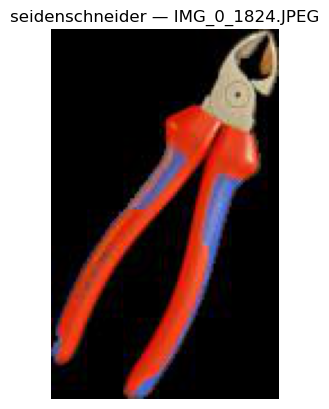

In [10]:
i = np.random.randint(len(test_paths))
bild = plt.imread(test_paths[i])
label = class_names[y_test_numeric[i]]
plt.imshow(bild)
plt.title(f"{label} — {Path(test_paths[i]).name}")
plt.axis('off')

In [11]:
yhat_test = loaded_model.predict(test_ds)
yhatnum_test = yhat_test.argmax(axis=1)

yhat_test.shape,y_test.shape


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step


((190, 3), (380,))

In [12]:
print(f"y_test (numerisch): {y_test_numeric[:10]}...")
print(f"yhatnum_test (Vorhersagen): {yhatnum_test[:10]}...")
print(f"\nAnzahl Test-Bilder: {len(y_test_numeric)}")
print(f"Anzahl Vorhersagen: {len(yhatnum_test)}")

y_test (numerisch): [0 0 0 0 0 0 0 0 0 0]...
yhatnum_test (Vorhersagen): [0 0 0 0 0 0 0 0 0 0]...

Anzahl Test-Bilder: 190
Anzahl Vorhersagen: 190


Das ist nun also der Klassenindex- da wir die Bilder nicht "geshuffled" haben, ist zumindest die Sequenz `y_test` monoton. Bei `yhatnum_test` (also unseren Vorhersagen auf diesen Bildern) gibt es einige wenige Abweichungen. Das ist zu erwarten. Wenn wir nur wüssten, welcher Klasse das zugehört?!  
Aber weil wir zu neugierig sind, wie gut das Modell sein könnte, rechnen wir ohne dieses Wissen mal die Genauigkeit aus:

In [13]:
Genauigkeit = np.mean(np.where(y_test_numeric==yhatnum_test,1,0)) 
# np.where könnte man auch weglassen, so: Genauigkeit = np.mean(y_test==yhatnum_test). 
# Aber was ist der Mittelwert von True, False, True? 
# Klarer ist's wenn wir mit where ersetzen: True->1 und False->0
assert Genauigkeit==np.mean(y_test_numeric==yhatnum_test) # Ergibt einen Fehler, sollte das mal nicht mehr stimmen
print(f'Die Testgenauigkeit ist {100*Genauigkeit:3.1f}%.')

Die Testgenauigkeit ist 23.7%.


Nun würden wir also auch gerne die Label kennen. Wir müssen den Labelindex (die Zahl) mit dem Namen der Klasse in Verbindung bringen. Zum Glück werden die Klassenlabel sortiert durchgezählt, so dass dieser Schritt nicht schwer ist:

In [14]:
# Verwende die class_names aus dem Dataset (bereits sortiert)
sorted_class_labels = np.array(class_names)
print(f"Sortierte Klassenlabels ({len(sorted_class_labels)} Klassen):")
print(sorted_class_labels)

Sortierte Klassenlabels (3 Klassen):
['schraubenschluessel' 'schraubenzieher' 'seidenschneider']


In [15]:
print(f"Test-Bilder: {len(test_paths)} Dateien")
print(f"Vorhersagen: {len(yhatnum_test)} Werte")
print(f"\nErste 5 Vorhersagen (Indices): {yhatnum_test[:5]}")
print(f"Entsprechende Klassen: {sorted_class_labels[yhatnum_test[:5]]}")

Test-Bilder: 190 Dateien
Vorhersagen: 190 Werte

Erste 5 Vorhersagen (Indices): [0 0 0 0 0]
Entsprechende Klassen: ['schraubenschluessel' 'schraubenschluessel' 'schraubenschluessel' 'schraubenschluessel' 'schraubenschluessel']


In [16]:
yhat_label = pd.Series(sorted_class_labels[yhatnum_test], index=test_paths)
y_test_label = pd.Series(sorted_class_labels[y_test_numeric], index=test_paths)
# das vorhergesagte Label:
print("Vorhergesagte Labels (erste 10):")
print(yhat_label.head(10))

Vorhergesagte Labels (erste 10):
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1749.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1750.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1754.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1755.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1758.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1762.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1767.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1768.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_2127.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_2129.JPEG    schraubenschluessel
dtype: object


In [17]:
# und das Tatsächliche:
y_test_label

Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1749.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1750.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1754.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1755.JPEG    schraubenschluessel
Baumstruktur\2_Baumstruktur_test\schraubenschluessel\IMG_0_1758.JPEG    schraubenschluessel
                                                                               ...         
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_0_2116.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_0_2122.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_1_1821.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_1_1825.JPEG            seidenschneider
Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_2_2051.JPEG            seid

In [18]:
# Natürlich muss die gleiche Genauigkeit rauskommen, wenn wir sie mit den Labels berechnen, anstatt mit den Labelindices:
Genauigkeit2 = (yhat_label==y_test_label).mean()
print(f'Die Testgenauigkeit ist {100*Genauigkeit2:3.1f}%.')

Die Testgenauigkeit ist 23.7%.


Schliesslich können wir uns noch die Wahrscheinlichkeit merken, mit welcher das Neuronale Netz eine Klasse identifiziert hat. Dies ist also die grösste Zahl unter den $P(y=c_i|X)$ für alle Klassen $c_1$,...,$c_C$ ($C$ der Anzahl Klassen unseres Problems, `yhat_test.shape[1]`.

In [19]:
P = np.max(yhat_test,axis=1)
P.shape

(190,)

# Scikit-Plot
Wir sind bereit! Wir kennen die Testbilder, deren zugehörige Klassenlabel und Vorhersagen durch das geladene Modell. Wir folgen der Dokumentation [hier](https://scikit-plot.readthedocs.io/en/stable/metrics.html). Berechnen wir Metriken! Wir beginnen mit der Confusion Matrix:

Classification Report:
                     precision    recall  f1-score   support

schraubenschluessel       0.24      1.00      0.38        45
    schraubenzieher       0.00      0.00      0.00        88
    seidenschneider       0.00      0.00      0.00        57

           accuracy                           0.24       190
          macro avg       0.08      0.33      0.13       190
       weighted avg       0.06      0.24      0.09       190



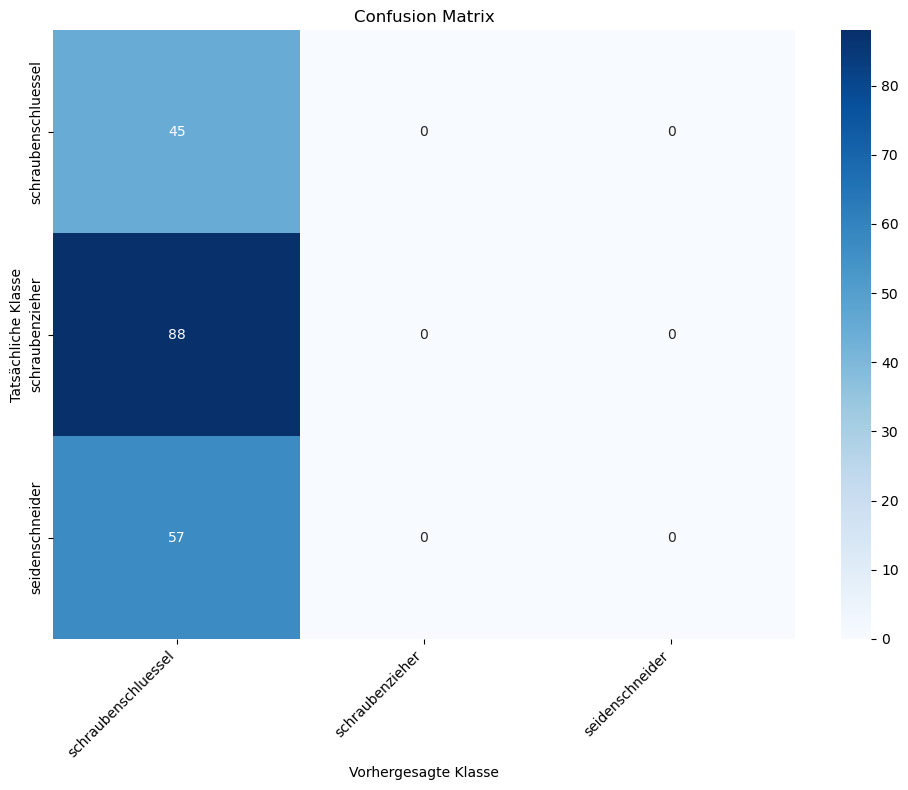

In [20]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_label, yhat_label, zero_division=0))

# Confusion Matrix (verwendet scikit-plot oder Alternative)
scikitplot.metrics.plot_confusion_matrix(
    y_test_label.values, 
    yhat_label.values, 
    labels=sorted_class_labels, 
    x_tick_rotation=45
)
plt.tight_layout()
plt.show()

Beachten Sie, wie hübsch blockdiagonal die confusion matrix geworden ist. Dies zeigt, dass das Modell sich meist in der Form, und selten bis nie in der Farbe irrt.  
Ein offensichtliches Problem ist natürlich, dass wir den Grossteil der Daten zum Training benutzt haben (das ist gängige Praxis), und nun nur wenige Beispiele (pro Klasse) übrig haben, um die Präzision und den Recall der Klasse zu schätzen. Mehr Daten wären schon praktisch...

In [21]:
display((y_test_label==yhat_label).value_counts())
print('-'*30)
for curr_class_str in yhat_label.unique():
    curr_class_results=(y_test_label[y_test_label==curr_class_str]==yhat_label[y_test_label==curr_class_str])
    print(f'{curr_class_str:<10}:{100*curr_class_results.mean():3.0f}%')

False    145
True      45
Name: count, dtype: int64

------------------------------
schraubenschluessel:100%


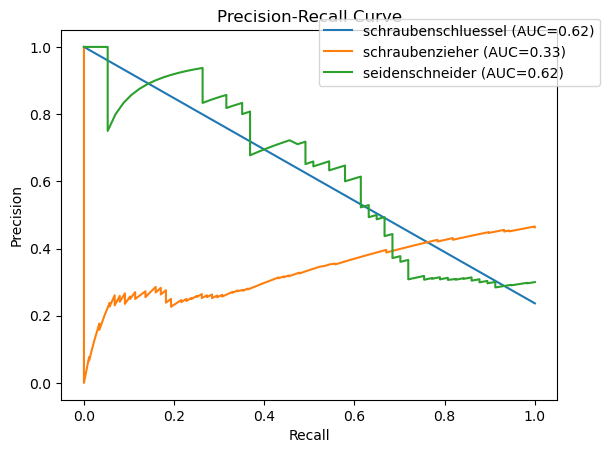

In [22]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_precision_recall(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

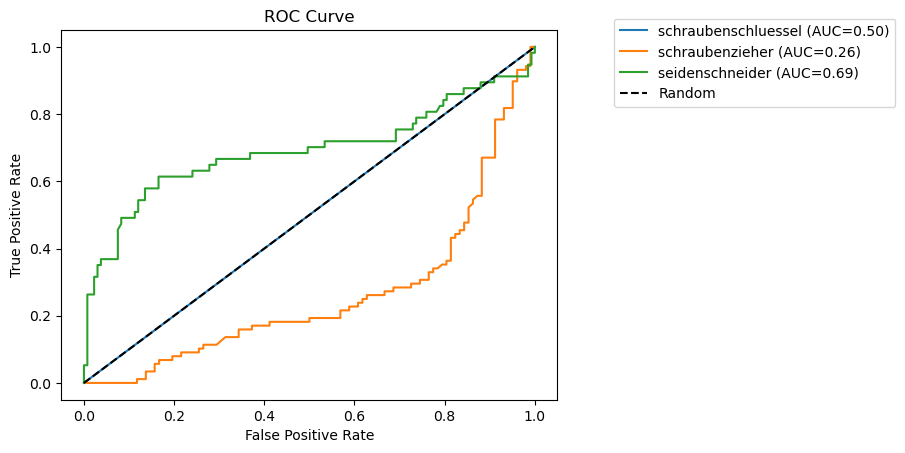

In [23]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_roc(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

Ein Problem hier ist, dass das neuronale Netz für recht viele Klassen ("area=1.000") eine extreme Precision-Recall-Kurve ausgibt- von (0,1) über (1,1) nach (1,0). Aber wer würde sich schon darüber beklagen!

Zur Erinnerung, dies ist das Modell, das die obigen Resultate erziehlt hat. Wir können es grundsätzlich irgendwo (auf einem Raspberry-Pi?) laden und dort Vorhersagen generieren.

In [24]:
loaded_model.layers[-1]

<Dense name=Ausgabe, built=True>

In [25]:
loaded_model.summary()

Model: "MobileNetV2-Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Eingabe (InputLayer)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ausgabe (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,198,795 (27.46 MB)

 Trainable params: 2,388,227 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,776,456 (18.22 MB)

# Conv Layer Outputs
In den nächsten paar Zeilen werden wir ("spasseshalber", ist nicht weiter wichtig), den Output der letzten Conv-Schicht ausgeben und visualisieren.

**Hinweis**: Der Code findet automatisch die letzte Conv2D-Schicht, unabhängig vom Layer-Namen.

In [26]:
# Finde automatisch die letzte Conv2D-Schicht (robust gegen verschiedene Layer-Namen)
# Unterstützt sowohl einfache CNN-Modelle als auch Transfer-Learning-Modelle (MobileNetV2, etc.)

def find_conv_layers(model):
    """Findet Conv2D-Schichten im Modell, auch in Submodellen (z.B. MobileNetV2)"""
    conv_layers = []
    
    # 1. Suche in Top-Level-Layern
    for layer in model.layers:
        # Prüfe ob Layer selbst Conv2D ist
        if isinstance(layer, tf.keras.layers.Conv2D):
            conv_layers.append(layer)
        # Prüfe ob Layer ein Submodell ist (z.B. MobileNetV2 Base-Modell)
        elif hasattr(layer, 'layers') and len(layer.layers) > 0:
            # Rekursiv in Submodell suchen
            sub_conv = find_conv_layers(layer)
            conv_layers.extend(sub_conv)
    
    return conv_layers

# Suche nach Conv2D-Schichten
conv_layers = find_conv_layers(loaded_model)

if conv_layers:
    conv_layer = conv_layers[-1]  # Nimm die letzte Conv2D-Schicht
    print(f"✓ Gefundene Conv2D-Schicht: {conv_layer.name}")
    print(f"  Typ: {type(conv_layer).__name__}")
    print(f"  Anzahl gefundener Conv2D-Schichten: {len(conv_layers)}")
    if len(conv_layers) <= 10:
        print(f"  Verfügbare Conv2D-Schichten: {[l.name for l in conv_layers]}")
    else:
        print(f"  Erste 5: {[l.name for l in conv_layers[:5]]}")
        print(f"  Letzte 5: {[l.name for l in conv_layers[-5:]]}")
else:
    # Fallback: Verwende die letzte Schicht vor GlobalAveragePooling2D oder Dense
    print("⚠️ Keine Conv2D-Schicht direkt gefunden. Suche nach alternativer Schicht...")
    for i, layer in enumerate(loaded_model.layers):
        if isinstance(layer, (tf.keras.layers.GlobalAveragePooling2D, tf.keras.layers.Dense)):
            if i > 0:
                # Verwende die vorherige Schicht
                conv_layer = loaded_model.layers[i-1]
                print(f"✓ Verwende alternative Schicht: {conv_layer.name} (Typ: {type(conv_layer).__name__})")
                break
    else:
        raise ValueError("Keine geeignete Schicht für Feature-Visualisierung gefunden!")

✓ Gefundene Conv2D-Schicht: Conv_1
  Typ: Conv2D
  Anzahl gefundener Conv2D-Schichten: 35
  Erste 5: ['Conv1', 'expanded_conv_project', 'block_1_expand', 'block_1_project', 'block_2_expand']
  Letzte 5: ['block_15_expand', 'block_15_project', 'block_16_expand', 'block_16_project', 'Conv_1']


In [ ]:
from tensorflow.keras import Model, Input

# Erstelle Feature-Modell für Visualisierung
# Bei Transfer-Learning-Modellen müssen wir den vollständigen Pfad durch Rescaling/Data Augmentation berücksichtigen

print("Erstelle Feature-Modell für Visualisierung...")

# Strategie: Finde die Schicht direkt vor GlobalAveragePooling2D
# Diese sollte das Base-Modell-Output sein, bereits durch alle Vorverarbeitungsschichten geführt
feature_output = None
found_layer_name = None

for i, layer in enumerate(loaded_model.layers):
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        if i > 0:
            # Die vorherige Schicht sollte das Base-Modell-Output sein
            prev_layer = loaded_model.layers[i-1]
            feature_output = prev_layer.output
            found_layer_name = prev_layer.name
            print(f"✓ Gefunden: Schicht vor GlobalAveragePooling2D = '{found_layer_name}'")
            print(f"  Typ: {type(prev_layer).__name__}")
            break

if feature_output is None:
    # Fallback: Versuche Base-Modell direkt zu finden
    print("⚠️ Keine GlobalAveragePooling2D-Schicht gefunden. Suche Base-Modell...")
    for layer in loaded_model.layers:
        if (hasattr(layer, 'layers') and len(layer.layers) > 10 and 
            isinstance(layer, tf.keras.Model)):
            feature_output = layer.output
            found_layer_name = layer.name
            print(f"✓ Gefunden: Base-Modell '{found_layer_name}'")
            break

if feature_output is None:
    raise ValueError("Konnte keine geeignete Schicht für Feature-Extraktion finden!")

# Erstelle Feature-Modell
# WICHTIG: Verwende loaded_model.input, damit der vollständige Pfad durch Rescaling/Data Augmentation berücksichtigt wird
try:
    feature_model = Model(
        inputs=loaded_model.input,
        outputs=feature_output,
        name="FeatureExtractor"
    )
    print(f"✓ Feature-Modell erfolgreich erstellt (Output: '{found_layer_name}')")
    
    # Teste das Modell mit einem Dummy-Input
    test_input = tf.random.normal((1, 128, 128, 3))
    test_output = feature_model(test_input, training=False)
    print(f"✓ Test erfolgreich: Output-Shape = {test_output.shape}")
except Exception as e:
    print(f"❌ Fehler beim Erstellen des Feature-Modells: {e}")
    print("\n⚠️ Alternative: Verwende die bereits gefundene Conv2D-Schicht...")
    
    # Fallback: Verwende die bereits gefundene conv_layer (aus vorheriger Zelle)
    if 'conv_layer' in globals() and conv_layer is not None:
        try:
            print(f"✓ Verwende Conv2D-Schicht: '{conv_layer.name}'")
            feature_model = Model(
                inputs=loaded_model.input,
                outputs=conv_layer.output,
                name="FeatureExtractor"
            )
            print(f"✓ Feature-Modell erfolgreich erstellt (Output: '{conv_layer.name}')")
            
            # Teste das Modell
            test_input = tf.random.normal((1, 128, 128, 3))
            test_output = feature_model(test_input, training=False)
            print(f"✓ Test erfolgreich: Output-Shape = {test_output.shape}")
        except Exception as e2:
            print(f"❌ Auch Conv2D-Ansatz fehlgeschlagen: {e2}")
            raise ValueError(f"Feature-Modell konnte nicht erstellt werden: {e2}")
    else:
        raise ValueError(f"Feature-Modell konnte nicht erstellt werden und keine Conv2D-Schicht verfügbar: {e}")


Erstelle Feature-Modell für Visualisierung...
✓ Gefunden: Schicht vor GlobalAveragePooling2D = 'mobilenetv2_1.00_128'
  Typ: Functional
✓ Feature-Modell erfolgreich erstellt (Output: 'mobilenetv2_1.00_128')
❌ Fehler beim Erstellen des Feature-Modells: "Exception encountered when calling Functional.call().\n\n\x1b495741808\x1b\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

Alternative: Verwende das vollständige Modell bis zur letzten Conv-Schicht


ValueError: Feature-Modell konnte nicht erstellt werden: "Exception encountered when calling Functional.call().\n\n\x1b[1m495741808\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [ ]:
from PIL import Image
import numpy as np

color_image_size = (128, 128)  # MUSS mit Training übereinstimmen!

# Verwende ein Test-Bild aus dem Dataset
if len(test_paths) > 0:
    # Wähle zufällig ein Bild aus den Test-Daten
    test_image_path = test_paths[np.random.randint(len(test_paths))]
    print(f"Verwende Test-Bild: {test_image_path}")
    
    im = Image.open(test_image_path)
    im_resized = im.resize(color_image_size, Image.Resampling.LANCZOS)
    img = np.array(im_resized) / 255.0  # Normalisierung
    
    # Batch-Dimension hinzufügen
    img_batch = img.reshape(1, *color_image_size, 3)
else:
    raise ValueError("Keine Test-Bilder gefunden!")


Verwende Test-Bild: Baumstruktur\2_Baumstruktur_test\seidenschneider\IMG_0_2008.JPEG


In [ ]:
feature_maps = feature_model.predict(img_batch)
print("Feature-Map Shape:", feature_maps.shape) 

KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m84692528\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)\n  • training=False\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

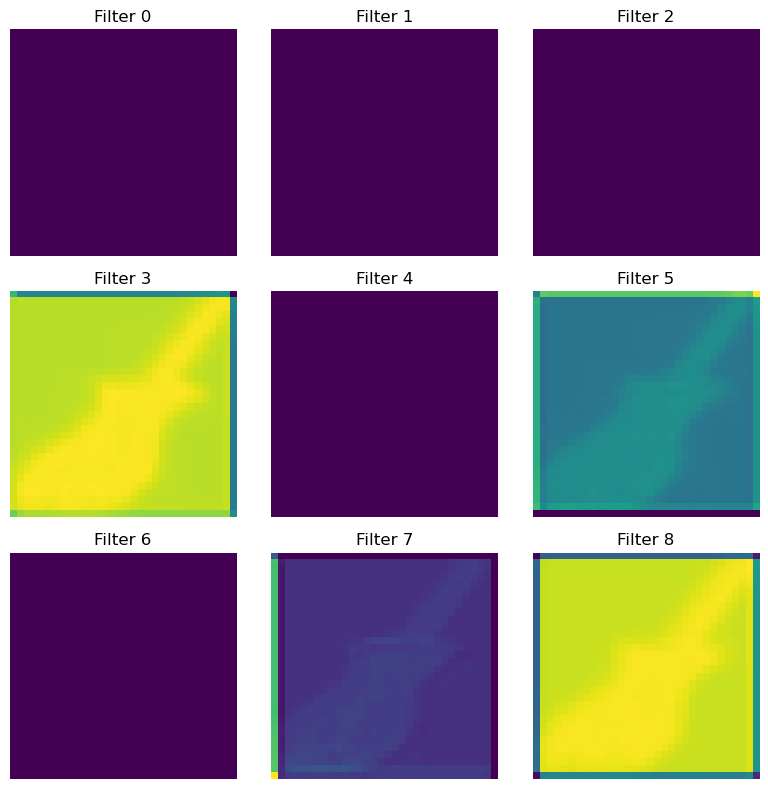

In [ ]:
import matplotlib.pyplot as plt

# Einzeln anzeigen (z. B. die ersten 9 Kanäle)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
    ax.set_title(f'Filter {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()
